# Feature Selection in Psychometric Questionnaires

### Valerio Rocca, 2094861

### Index

1. Introduction
2. Exploratory Data Analysis
3. Principal Component Analysis
4. Classification
    - K-NN
    - Random Forest
    - Logistic Regression
    - Support Vector Machine
    - Neural Network
5. Conclusions

### Introduction

The ratio between the number of participants and the number of questions in psychometric questionnaires can be high. This usually makes data unsuitable for Machine Learning applications. In this notebook, I explore solutions to this problem by studying different feature selection techniques over the PID-5 dataset.

PID-5, an acronym for Personality Inventory for DSM-5, is a self-report questionnaire designed to assess personality traits according to the DSM-5 classification system. The PID-5 comprises 220 items that assess the "Big Five" personality traits: negative affectivity, detachment, antagonism, disinhibition, and psychoticism. The values are expressed in a Likert scale, which can range from 0 ("every time or frequently false") to 3 ("every time or frequently true").

The dataset's rows are 824, as the 412 participants were asked to answer the questionnaire twice: the first by answering honestly, while the second by pretending to have a mental disorder. Thus, the objective of Machine Learning models is to assess whether a participant answers honestly. I will test the following architectures: K-NN, Random Forest, Logistic Regression, Support Vector Machine, and Feed Forward Neural Network.

As I mentioned, the analysis aims to understand if applying feature selection techniques allows the models to retain good performance. I will test both model-dependent and model-agnostic methods.

After an Exploratory Data Analysis, I will create two additional datasets by applying the Principal Component Analysis. One will be obtained by transforming the original dataset using the 20% most important features; the other using the most critical variables determined by the elbow method.

Then, the aforementioned models will be fine-tuned and tested on the datasets. The main findings will be reported in the conclusions.

### Exploratory Data Analysis

Import of the libraries.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Linear
from sklearn.model_selection import ParameterGrid
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import cross_val_score

Set the style for the plots (comment the following line to run the notebook without the style downloaded).

In [38]:
plt.style.use("rose-pine-moon.mplstyle")

Import of the dataset from a local repository, plus first operations to make it usable.

In [4]:
# Import the dataset (change the url to your repository)
url = "C:/Users/valer/Desktop/CBSD/CBSD_project/MD-PID5.xlsx"
df = pd.read_excel(url, header=0, engine="openpyxl")

# Data is stored into a single column, and answers are separated by semicolons.
# Separate the answers in different columns
df = df.iloc[:, 0].str.split(";", expand=True)

# Rename the columns
names = []
for i in range(1,221): names.append(f"Q{i}")
names.append("target")
df.columns = names

# Make the targets numeric (H -> 0; D -> 1)
df['target'] = df['target'].replace({'H': 0, 'D': 1})
df = df.astype(float)

# Extract the target and the covariates in, respectively, a vector y and a matrix X
X = df.iloc[:, :-1]
y = df.iloc[:, 220:221]

print(df)

      Q1   Q2   Q3   Q4   Q5   Q6   Q7   Q8   Q9  Q10  ...  Q212  Q213  Q214   
0    0.0  0.0  2.0  2.0  0.0  0.0  2.0  0.0  0.0  1.0  ...   0.0   0.0   2.0  \
1    0.0  1.0  1.0  2.0  2.0  1.0  1.0  0.0  1.0  0.0  ...   3.0   0.0   1.0   
2    1.0  0.0  0.0  1.0  1.0  1.0  2.0  1.0  2.0  1.0  ...   2.0   2.0   2.0   
3    2.0  0.0  1.0  2.0  2.0  2.0  2.0  0.0  2.0  1.0  ...   2.0   2.0   1.0   
4    2.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  2.0  1.0  ...   2.0   1.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
819  2.0  0.0  0.0  3.0  3.0  2.0  2.0  1.0  2.0  3.0  ...   1.0   1.0   3.0   
820  2.0  3.0  2.0  3.0  3.0  1.0  0.0  1.0  3.0  0.0  ...   1.0   3.0   2.0   
821  3.0  0.0  1.0  0.0  0.0  1.0  3.0  0.0  2.0  3.0  ...   0.0   3.0   0.0   
822  3.0  3.0  2.0  3.0  3.0  3.0  3.0  3.0  1.0  3.0  ...   1.0   3.0   3.0   
823  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  ...   0.0   3.0   3.0   

     Q215  Q216  Q217  Q218  Q219  Q220

Creation of two plots, both distinguished on the basis of the target variable.

1) Five-term Moving Average of the average answer to each question (Moving Average has been applied to enhance data visualization)

2) Standard deviation of the answers

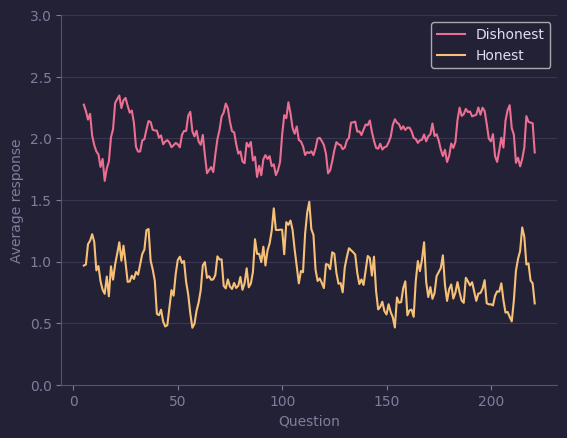

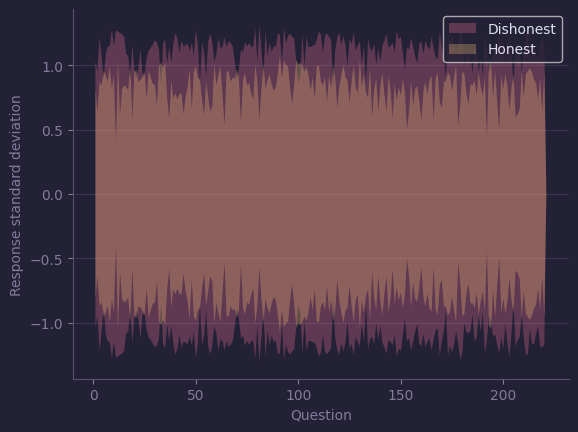

Average honest answer: 0.881; average standard deviation of the honest answers: 0.834
Average dishonest answer: 2.005; average standard deviation of the dishonest answers: 1.121


In [40]:
# --- Average answer ---

# For each variable and separated by classes, compute the mean and the std
mu0 = df[df["target"]==0].mean(axis=0)
mu1 = df[df["target"]==1].mean(axis=0)
sigma0 = df[df["target"]==0].std(axis=0)
sigma1 = df[df["target"]==1].std(axis=0)

# Apply a moving average
window = np.ones(5) / 5
mu0_ma = np.convolve(mu0, window, mode='valid')
mu1_ma = np.convolve(mu1, window, mode='valid')

# Plot the results
plt.plot(range(5, df.shape[-1]+1), mu1_ma)
plt.plot(range(5, df.shape[-1]+1), mu0_ma)

plt.ylabel("Average response")
plt.xlabel("Question")
plt.legend(["Dishonest", "Honest"])
plt.ylim(0, 3)

plt.show()


# --- Standard deviation of the answers ---

# Compute an array full of zeros
mu_fix = np.zeros(221)

# Plot the results
plt.fill_between(range(1, df.shape[-1]+1), mu_fix-sigma1, mu_fix+sigma1, alpha=0.3)
plt.fill_between(range(1, df.shape[-1]+1), mu_fix-sigma0, mu_fix+sigma0, alpha=0.3)

plt.ylabel("Response standard deviation")
plt.xlabel("Question")
plt.legend(["Dishonest", "Honest"])

plt.show()


# --- Print the average answer and std, divided by honest and dishonest ---
print(f"Average honest answer: {round(np.mean(mu0),3)}; average standard deviation of the honest answers: {round(np.mean(sigma0),3)}")
print(f"Average dishonest answer: {round(np.mean(mu1),3)}; average standard deviation of the dishonest answers: {round(np.mean(sigma1),3)}")


We observe a significant difference. When people are asked to answer dishonestly, on average they give higher Likert-scale values and, more interestingly, their answers have an higher variability. We want now to study which questions are associated with the higher discrepancies, both in terms of mean and standard deviation.

Mean discrepancies by question:
Q192    2.026699
Q2      2.007282
Q217    1.934466
Q139    1.917476
Q190    1.915049
          ...   
Q102   -0.050971
Q35    -0.123786
Q111   -0.152913
Q212   -0.470874
Q96    -0.604369
Length: 221, dtype: float64

Standard deviation discrepancies by question:
Q11     0.875570
Q198    0.750785
Q81     0.731420
Q192    0.708348
Q64     0.682882
          ...   
Q83    -0.093195
Q18    -0.115513
Q100   -0.144951
Q117   -0.169007
Q33    -0.174950
Length: 221, dtype: float64


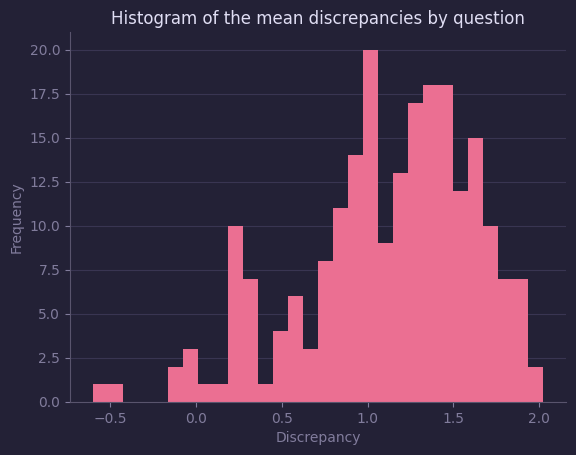

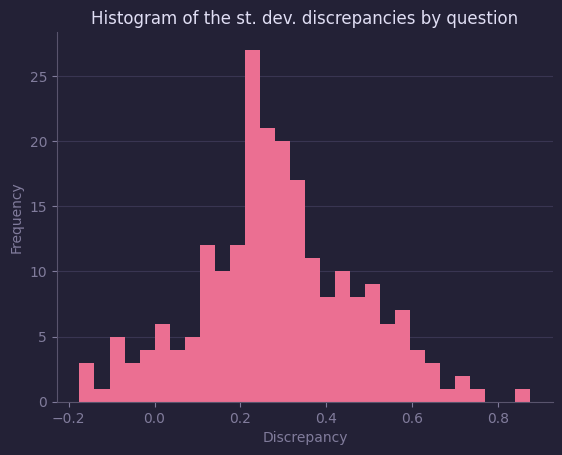

In [41]:
# For each question, compute the difference between honest and dishonest
# answers' values. Then, sort the resulting array
mu_diff = mu1 - mu0
mu_diff = mu_diff.sort_values(ascending=False)
print(f"Mean discrepancies by question:\n{mu_diff}")
print()

# Do the same as before, but with standard deviation
sigma_diff = sigma1 - sigma0
sigma_diff = sigma_diff.sort_values(ascending=False)
print(f"Standard deviation discrepancies by question:\n{sigma_diff}")

# Create two histograms to show the differences
# 1) Histogram related to the mean
plt.hist(mu_diff, bins=30)
plt.title("Histogram of the mean discrepancies by question")
plt.xlabel("Discrepancy")
plt.ylabel("Frequency")
plt.show()

# 2) Histogram related to the standard deviation
plt.hist(sigma_diff, bins=30)
plt.title("Histogram of the st. dev. discrepancies by question")
plt.xlabel("Discrepancy")
plt.ylabel("Frequency")
plt.show()


The three questions with the highest discrepancy in terms of average answers have a difference of around two, and they are:

- Question 192: "Sometimes I think someone else is removing thoughts from my head"
- Question 2: "A lot of people resent me"
- Question 217: "Often things around me seem unreal, or more real than usual"

Regarding standard deviation discrepancies, the three most variable answers are:

- Question 11: "I often initiate physical fights"
- Question 198: "The world would certainly be better off if I were dead"
- Question 81: "Sometimes I hit people to remind them who is in charge"

It is also interesting to observe that some answers have negative discrepancies. For example, concerning the mean, this is the case for questions 96 ("I rarely worry about anything") and 212 ("Many times I feel guilty"). While question 96's Likert score is supposed by design to be inverted compared to the other answers, this is not the case for question 212.

At the same time, about the standard deviation, this is the case for questions 33 ("Often my thoughts go off in bizarre or unusual directions") and 117 ("I am always on guard for someone who tries to cheat me or to harm me").

Finally, the histograms of the frequencies of the differences for the mean and the standard deviation are different. While the first one has a heavy tail on the left, the second one is more symmetrical and centered on the average value.

Let's now proceed by analysing the linear correlation between the features.

In [84]:
# Extract the position of the questions with a higher correlation than 0.85
corr = df.corr()
indices = np.where(corr.values > 0.85)
indices = [(indices[0][i], indices[1][i]) for i in range(len(indices[0])) if indices[0][i] < indices[1][i]]


print(indices)

[(18, 71), (53, 71), (71, 152), (71, 165), (152, 165), (152, 206), (165, 206), (205, 218)]


Follows a graph summarizing the most correlated questions.

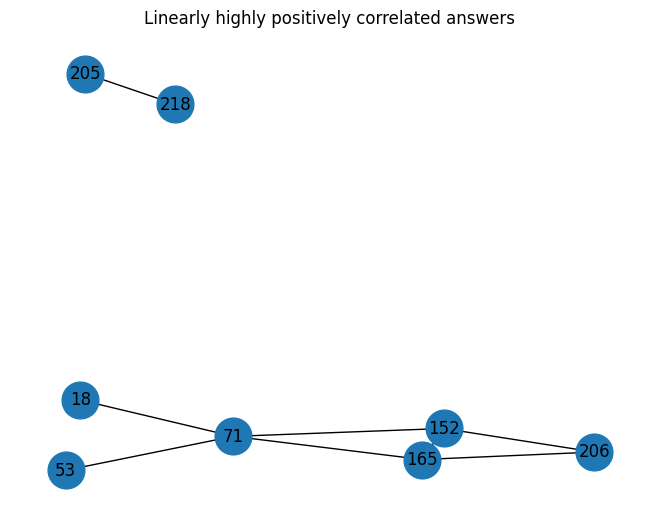

In [86]:
# Create an empty graph and add the edges to it
G = nx.Graph()
G.add_edges_from(indices)

nx.draw(G, with_labels=True, node_size=700)
plt.title("Linearly highly positively correlated answers").set_color("black")
plt.show()

From the top to the bottom, from the left to the right:

- Question 205: "I often have thoughts that make sense to me, but that other people say are strange"

- Question 218: "I exaggerate things if it is to my advantage"

- Question 18: "Sometimes my emotions change without a valid reason"

- Question 53: "I often invent things about myself so that they help me to
get what I want"

- Question 71: "My thoughts are strange and unpredictable"

- Question 152: "I think about things in such strange ways that for most most people don't make sense"

- Question 165: "I get emotional over every little thing"

- Question 206: "I use people to get what I want"







In [44]:
# Extract the position of the questions with a lower correlation than 0.65
indices = np.where(corr.values < -0.65)
indices = [(indices[0][i], indices[1][i]) for i in range(len(indices[0])) if indices[0][i] < indices[1][i]]

print(indices)

[]


There are no linearly negatively highly correlated questions.

### Principal Components Analysis

As we said, we are interested in evaluating the performance of the models both on the full dataset and on the dataset containing a subset of items. We use Principal Component Analysis as technique to perform model-agnostic feature selection.

The Principal Component Analysis (PCA) is a statistical technique used for reducing the dimensionality of a dataset while retaining as much of the variation in the data as possible. The goal of PCA is to identify the underlying structure in the data by finding the linear combinations of the original variables that explain the most variance, called principal components. The principal components are orthogonal to each other, meaning they are uncorrelated and capture different aspects of the variation in the data.

The number of components will be extracted using the elbow method, which is a graphical technique used to determine the optimal number of clusters in a dataset by plotting the explained variance as a function of the number of clusters, and selecting the "elbow" of the curve where the incremental gain starts diminishing.

Note that standardize data before performing the PCA is generally considered a good practice. I will not do it as the questionnaire already have standardized answers.

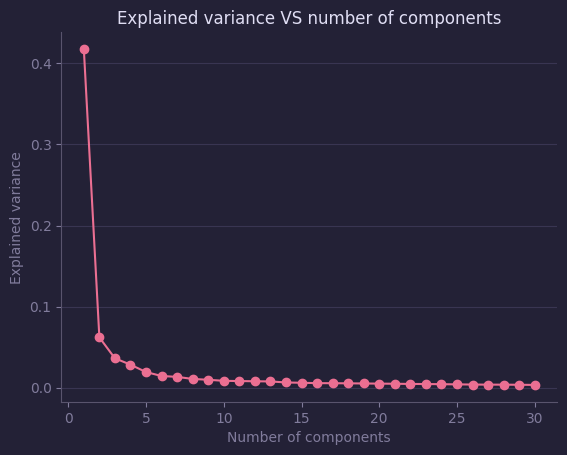

In [45]:
# Create a PCA object with 30 components
pca = PCA(n_components=30)

# Perform the PCA
pca.fit(X)

# Plot the explained variance as a function of the number of components
plt.plot(range(1, 31), pca.explained_variance_ratio_, marker='o')
plt.title("Explained variance VS number of components")
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

In [46]:
# Create two PCA objects: one, with the optimal number of components (three);
# the other, with the best 20% components
pca_opt = PCA(n_components=3)
pca_20 = PCA(n_components=44)

# Fit the PCA and transform the data
pca_opt.fit(X)
pca_20.fit(X)

X_opt = pca_opt.transform(X)
X_20 = pca_20.transform(X)

### Classification

Before proceeding with classification, I split the three datasets into training and test, using a 0.6-0.4 ratio. The validation set is not created as I will perform training using Cross Validation.

In [125]:
# Split data
X_train, X_test, X_opt_train, X_opt_test, X_20_train, X_20_test, y_train, y_test = \
    train_test_split(X, X_opt, X_20, y, test_size=0.4, random_state=123)

# Convert y_train and y_test to Numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

### K-NN

The K-Nearest Neighbors (K-NN) algorithm is a non-parametric machine learning model used for classification or regression. It works by finding the k closest data points in the training set to a new input, and then predicting the label or value of the new input based on the labels or values of the closest data points.

I firstly perform a Grid Search over the different K values, to find the most suitable one for each dataset. Then, I test their performance on the test set.

In [126]:
# Define a KNN classifier object
knn = KNeighborsClassifier()

# Define a grid of hyperparameters to search (i.e., all k between 1 and 50)
param_grid = dict(n_neighbors=list(range(1, 50)))

# Define the cross-validation strategy (cv = 5 means that the training set is
# divided into 5 subsets with the same number of elements and then, iteratively,
# 4 groups are used for training and 1 for validation)
cv = 5

# Perform a grid search for the best k value in the three datasets
grid = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy')
grid.fit(X_train, y_train.ravel())

grid_20 = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy')
grid_20.fit(X_20_train, y_train.ravel())

grid_opt = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy')
grid_opt.fit(X_opt_train, y_train.ravel())

# For each dataset, print the best k value and the corresponding accuracy
print("--- Model trained on X ---")
print(f"Best k value: {grid.best_params_['n_neighbors']}")
print(f"Best accuracy: {round(grid.best_score_,3)}")
print("--- Model trained on X_opt  ---")
print(f"Best k value: {grid_opt.best_params_['n_neighbors']}")
print(f"Best accuracy: {round(grid_opt.best_score_,3)}")
print("--- Model trained on X_20  ---")
print(f"Best k value: {grid_20.best_params_['n_neighbors']}")
print(f"Best accuracy: {round(grid_20.best_score_,3)}")

--- Model trained on X ---
Best k value: 3
Best accuracy: 0.917
--- Model trained on X_opt  ---
Best k value: 17
Best accuracy: 0.925
--- Model trained on X_20  ---
Best k value: 3
Best accuracy: 0.927


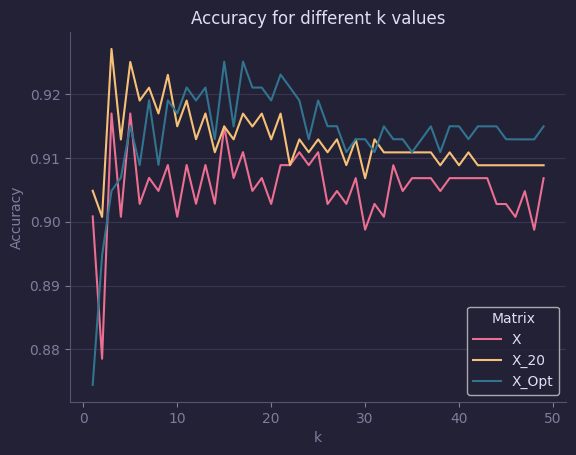

In [127]:
# Lineplot of the accuracy for each value of k
fig, ax = plt.subplots()
ax.plot(range(1, 50), grid.cv_results_['mean_test_score'], label='X')
ax.plot(range(1, 50), grid_20.cv_results_['mean_test_score'], label='X_20')
ax.plot(range(1, 50), grid_opt.cv_results_['mean_test_score'], label='X_Opt', color="#31748F")
ax.set_xlabel('k')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for different k values')
ax.legend(title='Matrix')
plt.show()

Best models on X_20 and X_opt perform slightly better than the ones on X. Moreover, all of them have a lower average performance for k>30.

In [128]:
# Test the KNNs with the best k value on the test set

# Build again three KNeigborsClassifier objects
knn_X = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
knn_opt = KNeighborsClassifier(n_neighbors=grid_opt.best_params_['n_neighbors'])
knn_20 = KNeighborsClassifier(n_neighbors=grid_20.best_params_['n_neighbors'])

# Fit them on the training set
knn_X.fit(X_train, y_train.ravel())
knn_opt.fit(X_opt_train, y_train.ravel())
knn_20.fit(X_20_train, y_train.ravel())

# Predict their values, and also compute the accuracy, the false positive
# and the false negative rates
pred_X = knn_X.predict(X_test)
pred_opt = knn_opt.predict(X_opt_test)
pred_20 = knn_20.predict(X_20_test)

knn_accuracy_X = accuracy_score(y_test, pred_X)
knn_accuracy_opt = accuracy_score(y_test, pred_opt)
knn_accuracy_20 = accuracy_score(y_test, pred_20)

tn_X, fp_X, fn_X, tp_X = confusion_matrix(y_test, pred_X).ravel()
tn_opt, fp_opt, fn_opt, tp_opt = confusion_matrix(y_test, pred_opt).ravel()
tn_20, fp_20, fn_20, tp_20 = confusion_matrix(y_test, pred_20).ravel()

print(f"--- KNN test accuracies ---")
print(f"Model trained on X: {round(knn_accuracy_X,3)} --- False Positive Rate: {round(fp_X / (fp_X + tn_X),3)} --- False Negative Rate: {round(fn_X / (fn_X + tp_X),3)}")
print(f"Model trained on X_opt: {round(knn_accuracy_opt,3)} --- False Positive Rate: {round(fp_opt / (fp_opt + tn_opt),3)} --- False Negative Rate: {round(fn_opt / (fn_opt + tp_opt),3)}")
print(f"Model trained on X_20: {round(knn_accuracy_20,3)} --- False Positive Rate: {round(fp_X / (fp_20 + tn_20),3)} --- False Negative Rate: {round(fn_20 / (fn_20 + tp_20),3)}")

--- KNN test accuracies ---
Model trained on X: 0.933 --- False Positive Rate: 0.006 --- False Negative Rate: 0.133
Model trained on X_opt: 0.948 --- False Positive Rate: 0.006 --- False Negative Rate: 0.101
Model trained on X_20: 0.948 --- False Positive Rate: 0.006 --- False Negative Rate: 0.089


Also on the test sets, all the models are able to reach a good accuracy. It is interesting to note that all of them as a FPR near zero: this is a common pattern in the models we will test, except of Logistic Regression.

### Random Forest

Random forest is a machine learning algorithm that creates multiple decision trees and combines them to make predictions (in this case, 200 for each dataset). Each decision tree is built using a random subset of the data and features, which helps to reduce overfitting and increase accuracy. The final prediction is made by combining the predictions of all the decision trees.

As I mentioned earlier, one of the key advantages of random forest is that it can automatically perform feature selection and feature importance ranking. This is because during the construction of each decision tree, the algorithm evaluates the importance of each feature in reducing the impurity or variance of the target variable.

For each of the three datasets, we explore different values for the parameter "max_depth", to find the most suitable compromise between accuracy and complexity.

In [129]:
# For ease of reading, I will not report the comments of code if it is similar
# to the one written already for the KNN.

rf = RandomForestClassifier(n_estimators=200)
param_grid = dict(max_depth=list(range(1, 700, 20)))

grid = GridSearchCV(rf, param_grid, cv=cv, scoring='accuracy')
grid.fit(X_train, y_train.ravel())

grid_20 = GridSearchCV(rf, param_grid, cv=cv, scoring='accuracy')
grid_20.fit(X_20_train, y_train.ravel())

grid_opt = GridSearchCV(rf, param_grid, cv=cv, scoring='accuracy')
grid_opt.fit(X_opt_train, y_train.ravel())

print("--- Model trained on X ---")
print(f"Best max_depth value: {grid.best_params_['max_depth']}")
print(f"Best accuracy: {round(grid.best_score_,3)}")
print("--- Model trained on X_opt  ---")
print(f"Best max_depth value: {grid_opt.best_params_['max_depth']}")
print(f"Best accuracy: {round(grid_opt.best_score_,3)}")
print("--- Model trained on X_20  ---")
print(f"Best max_depth value: {grid_20.best_params_['max_depth']}")
print(f"Best accuracy: {round(grid_20.best_score_,3)}")

--- Model trained on X ---
Best max_depth value: 421
Best accuracy: 0.951
--- Model trained on X_opt  ---
Best max_depth value: 1
Best accuracy: 0.921
--- Model trained on X_20  ---
Best max_depth value: 101
Best accuracy: 0.956


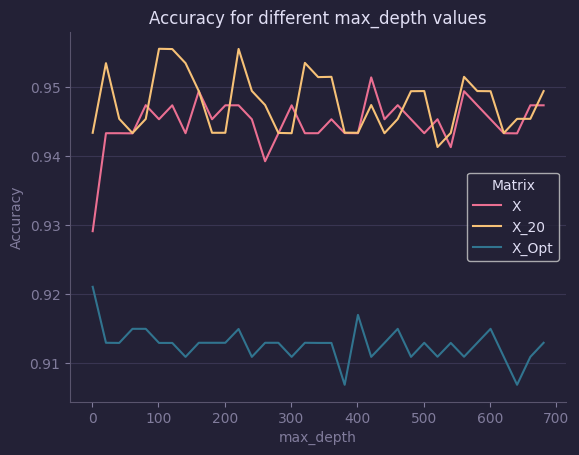

In [130]:
fig, ax = plt.subplots()
ax.plot(range(1, 700, 20), grid.cv_results_['mean_test_score'], label='X')
ax.plot(range(1, 700, 20), grid_20.cv_results_['mean_test_score'], label='X_20')
ax.plot(range(1, 700, 20), grid_opt.cv_results_['mean_test_score'], label='X_Opt', color="#31748F")
ax.set_xlabel('max_depth')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for different max_depth values')
ax.legend(title='Matrix')
plt.show()

Using Random Forest classifier, the difference between X and X_20 performances is negligible, while X_opt has a significantly lower accuracy.

In [131]:
rf_X = RandomForestClassifier(n_estimators=200, max_depth=grid.best_params_['max_depth'])
rf_opt = RandomForestClassifier(n_estimators=200, max_depth=grid_opt.best_params_['max_depth'])
rf_20 = RandomForestClassifier(n_estimators=200, max_depth=grid_20.best_params_['max_depth'])

rf_X.fit(X_train, y_train.ravel())
rf_opt.fit(X_opt_train, y_train.ravel())
rf_20.fit(X_20_train, y_train.ravel())

pred_X = rf_X.predict(X_test)
pred_opt = rf_opt.predict(X_opt_test)
pred_20 = rf_20.predict(X_20_test)

rf_accuracy_X = accuracy_score(y_test, pred_X)
rf_accuracy_opt = accuracy_score(y_test, pred_opt)
rf_accuracy_20 = accuracy_score(y_test, pred_20)

tn_X, fp_X, fn_X, tp_X = confusion_matrix(y_test, pred_X).ravel()
tn_opt, fp_opt, fn_opt, tp_opt = confusion_matrix(y_test, pred_opt).ravel()
tn_20, fp_20, fn_20, tp_20 = confusion_matrix(y_test, pred_20).ravel()

print(f"--- Random Forest test accuracies ---")
print(f"Model trained on X: {round(rf_accuracy_X,3)} --- False Positive Rate: {round(fp_X / (fp_X + tn_X),3)} --- False Negative Rate: {round(fn_X / (fn_X + tp_X),3)}")
print(f"Model trained on X_opt: {round(rf_accuracy_opt,3)} --- False Positive Rate: {round(fp_opt / (fp_opt + tn_opt),3)} --- False Negative Rate: {round(fn_opt / (fn_opt + tp_opt),3)}")
print(f"Model trained on X_20: {round(rf_accuracy_20,3)} --- False Positive Rate: {round(fp_X / (fp_20 + tn_20),3)} --- False Negative Rate: {round(fn_20 / (fn_20 + tp_20),3)}")

--- Random Forest test accuracies ---
Model trained on X: 0.973 --- False Positive Rate: 0.006 --- False Negative Rate: 0.051
Model trained on X_opt: 0.948 --- False Positive Rate: 0.006 --- False Negative Rate: 0.101
Model trained on X_20: 0.97 --- False Positive Rate: 0.006 --- False Negative Rate: 0.051


The test confirms the results observed during training: while there is no significant difference between X and X_20, there is a more important difference with respect to X_opt (<2.5% accuracy).

### Logistic Regression

Logistic regression is a statistical technique used to solve binary classification problems, where the dependent variable can have only two possible outcomes. It models the probability of an event occurring by fitting a logistic function to the data, which maps the input values to a probability value between 0 and 1. The model parameters are estimated using maximum likelihood estimation.

This technique implements specific feature selection methods. Here we implements the most important two: Ridge and Lasso regularisation.

In [232]:
# List of penalties
penalties = [None, 'l1', 'l2']

# List of train matrices
X_list = [(X_train,X_test), (X_20_train,X_20_test), (X_opt_train,X_opt_test)]

# Iterate over the feature matrices
for i, (X_tr,X_te) in enumerate(X_list):

    # Choose what to print on the basis of X value
    if i == 0:
        print(f"--- Matrix X ---")
    elif i == 1:
        print(f"--- Matrix X_20 ---")
    else:
        print(f"--- Matrix X_opt ---")

    # Iterate over the penalties
    for penalty in penalties:
        
        # The if/else condition is needed as L1 regularisation does not wor
        # with "lbfgs" solver
        if penalty == 'l1':
            lr = LogisticRegression(penalty=penalty, solver='liblinear',max_iter=1000)
        else:
            lr = LogisticRegression(penalty=penalty, solver='lbfgs', max_iter=1000)
        
        lr.fit(X_tr, y_train.ravel())

        # Compute Cross-Validation and then the accuracy
        accuracies = cross_val_score(lr, X_tr, y_train.ravel(), cv=5, scoring='accuracy')
        mean_accuracy = accuracies.mean()

        test_acc = accuracy_score(y_test, lr.predict(X_te))

        # Print the results
        print(f'Penalty: {penalty} - Accuracy: {round(mean_accuracy,3)} - Number of nonzero features: {(lr.coef_ != 0).sum()} - Test accuracy: {round(test_acc,3)}')

--- Matrix X ---
Penalty: None - Accuracy: 0.941 - Number of nonzero features: 220 - Test accuracy: 0.952
Penalty: l1 - Accuracy: 0.941 - Number of nonzero features: 86 - Test accuracy: 0.961
Penalty: l2 - Accuracy: 0.945 - Number of nonzero features: 220 - Test accuracy: 0.964
--- Matrix X_20 ---
Penalty: None - Accuracy: 0.899 - Number of nonzero features: 44 - Test accuracy: 0.945
Penalty: l1 - Accuracy: 0.935 - Number of nonzero features: 40 - Test accuracy: 0.955
Penalty: l2 - Accuracy: 0.919 - Number of nonzero features: 44 - Test accuracy: 0.964
--- Matrix X_opt ---
Penalty: None - Accuracy: 0.919 - Number of nonzero features: 3 - Test accuracy: 0.945
Penalty: l1 - Accuracy: 0.919 - Number of nonzero features: 3 - Test accuracy: 0.945
Penalty: l2 - Accuracy: 0.919 - Number of nonzero features: 3 - Test accuracy: 0.945


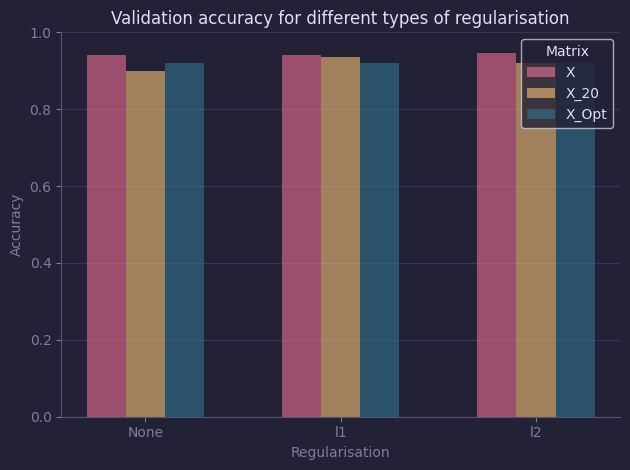

In [233]:
# Extract the mean cross-validated accuracy scores for each hyperparameter combination
scores = [[0.941,0.941,0.945],[0.899,0.935,0.919],[0.919,0.919,0.919]]

# Create a bar plot of the scores
x = np.arange(len(scores[0]))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, scores[0], width, label='X',alpha=0.6)
rects2 = ax.bar(x, scores[1], width, label='X_20',alpha=0.6)
rects3 = ax.bar(x + width, scores[2], width, label='X_Opt', color="#31748F",alpha=0.6)

ax.set_xlabel('Regularisation')
ax.set_ylabel('Accuracy')
ax.set_title('Validation accuracy for different types of regularisation')
ax.set_xticks(x)
ax.set_xticklabels(['None', 'l1', 'l2'])
ax.legend(title='Matrix')

# Set the y-axis range to go from 0 to 100
ax.set_ylim([0, 1])

fig.tight_layout()
plt.show()

L1 regularisation affeted heavily the number of features of X, reducing them from 220 to 86 while keeping untouched the accuracy. Besides this noticeable case, other input matrices were not - or not at all - affected by regularisation.

### Support Vector Machine

Support Vector Machine (SVM) is a supervised machine learning algorithm used for classification and regression analysis. SVM constructs a hyperplane in a high-dimensional space to separate data into different classes. The hyperplane is chosen such that it maximizes the margin, which is the distance between the hyperplane and the closest data points of each class.

SVM also implements a penalty parameter of the error term, called C. It controls the trade-off between a smooth decision boundary and correctly classifying the training points.

Also in this case, I will perform a Grid Search to find the most suitable C parameter for each dataset. Specifically, I will test 200 exponentially increasing parameters from 0.05 to 100. I chose to not create uniformly the hyperparameters as it would have been resulted in a in a too thick grain for small values.

In [136]:
svc = svm.SVC()
param_grid = dict(C=list(np.logspace(np.log10(0.05), np.log10(100), 200)))

grid = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy')
grid.fit(X_train, y_train.ravel())

grid_20 = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy')
grid_20.fit(X_20_train, y_train.ravel())

grid_opt = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy')
grid_opt.fit(X_opt_train, y_train.ravel())

print("--- Model trained on X ---")
print(f"Best C value: {grid.best_params_['C']}")
print(f"Best accuracy: {round(grid.best_score_,3)}")
print("--- Model trained on X_opt  ---")
print(f"Best C value: {grid_opt.best_params_['C']}")
print(f"Best accuracy: {round(grid_opt.best_score_,3)}")
print("--- Model trained on X_20  ---")
print(f"Best C value: {grid_20.best_params_['C']}")
print(f"Best accuracy: {round(grid_20.best_score_,3)}")

--- Model trained on X ---
Best C value: 6.392305006544103
Best accuracy: 0.957
--- Model trained on X_opt  ---
Best C value: 0.09943874444484177
Best accuracy: 0.929
--- Model trained on X_20  ---
Best C value: 5.922175975270565
Best accuracy: 0.962


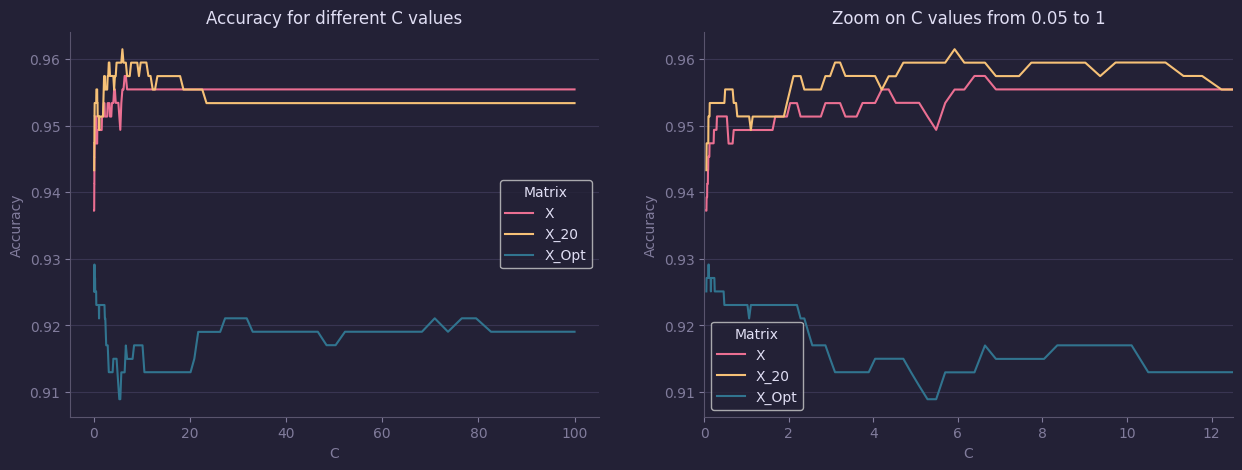

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

C_values = np.logspace(np.log10(0.05), np.log10(100), 200)

# First subplot
ax1.plot(C_values, grid.cv_results_['mean_test_score'], label='X')
ax1.plot(C_values, grid_20.cv_results_['mean_test_score'], label='X_20')
ax1.plot(C_values, grid_opt.cv_results_['mean_test_score'], label='X_Opt', color="#31748F")
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy for different C values')
ax1.legend(title='Matrix')

# Second subplot
ax2.plot(C_values, grid.cv_results_['mean_test_score'], label='X')
ax2.plot(C_values, grid_20.cv_results_['mean_test_score'], label='X_20')
ax2.plot(C_values, grid_opt.cv_results_['mean_test_score'], label='X_Opt', color="#31748F")
ax2.set_xlim(0, 12.5)
ax2.set_xlabel('C')
ax2.set_ylabel('Accuracy')
ax2.set_title('Zoom on C values from 0.05 to 1')
ax2.legend(title='Matrix')

plt.show()

The pattern is similar to Random Forest's one: X and X_20 have a similar performance, while X_opt underperforms.

In [138]:
svc_X = svm.SVC(C=grid.best_params_['C'])
svc_opt = svm.SVC(C=grid_opt.best_params_['C'])
svc_20 = svm.SVC(C=grid_20.best_params_['C'])

svc_X.fit(X_train, y_train.ravel())
svc_opt.fit(X_opt_train, y_train.ravel())
svc_20.fit(X_20_train, y_train.ravel())

pred_X = svc_X.predict(X_test)
pred_opt = svc_opt.predict(X_opt_test)
pred_20 = svc_20.predict(X_20_test)

svc_accuracy_X = accuracy_score(y_test, pred_X)
svc_accuracy_opt = accuracy_score(y_test, pred_opt)
svc_accuracy_20 = accuracy_score(y_test, pred_20)

tn_X, fp_X, fn_X, tp_X = confusion_matrix(y_test, pred_X).ravel()
tn_opt, fp_opt, fn_opt, tp_opt = confusion_matrix(y_test, pred_opt).ravel()
tn_20, fp_20, fn_20, tp_20 = confusion_matrix(y_test, pred_20).ravel()

print(f"--- SVM test accuracies ---")
print(f"Model trained on X: {round(svc_accuracy_X,3)} --- False Positive Rate: {round(fp_X / (fp_X + tn_X),3)} --- False Negative Rate: {round(fn_X / (fn_X + tp_X),3)}")
print(f"Model trained on X_opt: {round(svc_accuracy_opt,3)} --- False Positive Rate: {round(fp_opt / (fp_opt + tn_opt),3)} --- False Negative Rate: {round(fn_opt / (fn_opt + tp_opt),3)}")
print(f"Model trained on X_20: {round(svc_accuracy_20,3)} --- False Positive Rate: {round(fp_X / (fp_20 + tn_20),3)} --- False Negative Rate: {round(fn_20 / (fn_20 + tp_20),3)}")

--- SVM test accuracies ---
Model trained on X: 0.973 --- False Positive Rate: 0.006 --- False Negative Rate: 0.051
Model trained on X_opt: 0.955 --- False Positive Rate: 0.006 --- False Negative Rate: 0.089
Model trained on X_20: 0.967 --- False Positive Rate: 0.006 --- False Negative Rate: 0.038


The findings are, again, similar to Random Forest's ones.

### Feed Forward Neural Network

A Neural Network is a computational learning system that uses a network of nodes, or artificial neurons, organized in layers. Each node connects to another and has an associated weight and threshold. The output of any individual node is determined by an activation function applied to the weighted sum of its inputs. If the output exceeds a given threshold, the node is activated, sending data to the next layer of the network.

In this notebook, I will implement a Feed Forward Neural Network, which is an architecture in which the connections between nodes do not form a cycle. This means that information always moves in one direction, from the input nodes, through the hidden nodes (if any), and to the output nodes.

The FFNN implemented consists of one hidden layer, separated from the input through a ReLU activation function. The other parameters (number of neurons in the hidden layer, learning rate and dropout probability) are find through a Grid Search.

In [170]:
# Create the class FeedforwardNetowrk
class FeedforwardNetwork(nn.Module):

    # Define the intialising function
    def __init__(self, input_size, hidden_size, output_size, dropout_p):
        super(FeedforwardNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout = nn.Dropout(dropout_p)
        
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = nn.Sigmoid()

    # Define the forward function (i.e., the structure of the network)        
    def forward(self, x):
        x = x.to(self.fc1.weight.dtype)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

Define the Grid of Parameters and create the DataLoader objects.

In [169]:
param_grid = {
    'hidden_size': [32, 64, 128, 256],
    'dropout_prob': [0.0, 0.2, 0.4, 0.5],
    'eta': [0.001, 0.01, 0.1]
}

param_list = list(ParameterGrid(param_grid))

# Split training data in training and validation, as here I cannot apply
# Cross Validation
ffn_train, ffn_val, ffn_opt_train, ffn_opt_val, ffn_20_train, ffn_20_val, ffn_y_train, ffn_y_val = \
    train_test_split(X_train, X_opt_train, X_20_train, y_train, test_size=0.4, random_state=123)

# Transform all the vectors and matrices in tensors, to be acceptable
# from the FFNN
ffn_train = torch.tensor(ffn_train.values)
ffn_val = torch.tensor(ffn_val.values)
ffn_test = torch.tensor(X_test.values)

ffn_20_train = torch.tensor(ffn_20_train)
ffn_20_val = torch.tensor(ffn_20_val)
ffn_20_test = torch.tensor(X_20_test)

ffn_opt_train = torch.tensor(ffn_opt_train)
ffn_opt_val = torch.tensor(ffn_opt_val)
ffn_opt_test = torch.tensor(X_opt_test)

ffn_y_train = torch.tensor(ffn_y_train)
ffn_y_val = torch.tensor(ffn_y_val)
ffn_y_test = torch.tensor(y_test)

# Define the batch size
batch_size = 32

# Create DataLoader objects, needed from the FFNN to "load" data into it.
# "shuffle=True" means that, after each epoch, the minibatch are randomly recreated
train_loader = DataLoader(TensorDataset(ffn_train, ffn_y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(ffn_val, ffn_y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(ffn_test, ffn_y_test), batch_size=batch_size, shuffle=False)

train_20_loader = DataLoader(TensorDataset(ffn_20_train, ffn_y_train), batch_size=batch_size, shuffle=True)
val_20_loader = DataLoader(TensorDataset(ffn_20_val, ffn_y_val), batch_size=batch_size, shuffle=False)
test_20_loader = DataLoader(TensorDataset(ffn_20_test, ffn_y_test), batch_size=batch_size, shuffle=False)

train_opt_loader = DataLoader(TensorDataset(ffn_opt_train, ffn_y_train), batch_size=batch_size, shuffle=True)
val_opt_loader = DataLoader(TensorDataset(ffn_opt_val, ffn_y_val), batch_size=batch_size, shuffle=False)
test_opt_loader = DataLoader(TensorDataset(ffn_opt_test, ffn_y_test), batch_size=batch_size, shuffle=False)

# Build 3 Pandas dataframes to store the hyperparameters and the results
columns = ['hidden_size', 'dropout_prob', 'learn_rate', 'val_accuracy']
ffn_X_results = pd.DataFrame(np.zeros((48, 4)), columns=columns)
ffn_20_results = pd.DataFrame(np.zeros((48, 4)), columns=columns)
ffn_opt_results = pd.DataFrame(np.zeros((48, 4)), columns=columns)

Define the training and validation function for the FFNN.

In [171]:
def FFN_TRAIN(net, train_loader, val_loader, num_epochs, learning_rate):

    global ffn_results

    # Set the device to run on (GPU if available, oterwise CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device)
    
    # Set the loss function (Binary Cross Entropy) and the optimizer
    # (Stochastic Gradient Descent)
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

    # Train the network for the specified number of epochs
    for epoch in range(num_epochs):
        # Set the network to training mode
        net.train()
        
        # Loop over the training data
        for inputs, targets in train_loader:
            # Move the data to the device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs.float(), targets.float())
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        # Set the network to evaluation mode
        net.eval()
        
        # Evaluate the network on the validation data
        val_accs = []
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = net(val_inputs)
            val_preds = np.where(val_outputs>0.5,1,0)
            val_acc = accuracy_score(val_targets.cpu().numpy(), val_preds)
            val_accs.append(val_acc)
        mean_val_acc = np.mean(val_accs)
        
        # Print the validation accuracy
        if epoch%5 == 0:
            print(f'Epoch {epoch}: Validation accuracy = {mean_val_acc:.4f}')
        
    return mean_val_acc

Define the test function for the FFNN.

In [172]:
def FFN_TEST(net, test_loader):
    # Set the device to run on (GPU if available, oterwise CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device)
    
    # Set the network to evaluation mode
    net.eval()
    
    # Initialize the list of predictions and targets
    all_preds = []
    all_targets = []
    
    # Loop over the test data
    for inputs, targets in test_loader:
        # Move the data to the device
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = net(inputs)
        preds = np.where(outputs>0.5,1,0)

        # Append the predictions and targets to the lists
        all_preds.extend(preds)
        all_targets.extend(targets.cpu().numpy())
    
    print(f"--> Test accuracy: {round(accuracy_score(all_targets, all_preds),3)}")

Perform Grid Search over the three datasets.

In [173]:
print("########## Performing grid search over X ##########")
i = 0
for params in param_list:
    print(f"--- Hidden size: {params['hidden_size']}, dropout prob: {params['dropout_prob']}, learning rate: {params['eta']} ---")
    # Create a new instance of the FeedforwardNetwork class with the current hyperparameters
    my_model = FeedforwardNetwork(X.shape[1], params['hidden_size'], 1, params['dropout_prob'])
    # Call the training function
    val_acc = FFN_TRAIN(my_model, train_loader, val_loader, 21, params['eta'])
    # Put values in array
    ffn_X_results.loc[i, 'hidden_size'] = params['hidden_size']
    ffn_X_results.loc[i, 'dropout_prob'] = params['dropout_prob']
    ffn_X_results.loc[i, 'learn_rate'] = params['eta']
    ffn_X_results.loc[i, 'val_accuracy'] = val_acc
    i+=1


print("########## Performing grid search over X_20 ##########")
i = 0
for params in param_list:
    print(f"--- Hidden size: {params['hidden_size']}, dropout prob: {params['dropout_prob']}, learning rate: {params['eta']} ---")
    
    my_model = FeedforwardNetwork(X.shape[1], params['hidden_size'], 1, params['dropout_prob'])
    val_acc = FFN_TRAIN(my_model, train_loader, val_loader, 21, params['eta'])
    
    ffn_20_results.loc[i, 'hidden_size'] = params['hidden_size']
    ffn_20_results.loc[i, 'dropout_prob'] = params['dropout_prob']
    ffn_20_results.loc[i, 'learn_rate'] = params['eta']
    ffn_20_results.loc[i, 'val_accuracy'] = val_acc
    i+=1


print("########## Performing grid search over X_opt ##########")
i = 0
for params in param_list:
    print(f"--- Hidden size: {params['hidden_size']}, dropout prob: {params['dropout_prob']}, learning rate: {params['eta']} ---")
    
    my_model = FeedforwardNetwork(X.shape[1], params['hidden_size'], 1, params['dropout_prob'])
    val_acc = FFN_TRAIN(my_model, train_loader, val_loader, 21, params['eta'])
    
    ffn_opt_results.loc[i, 'hidden_size'] = params['hidden_size']
    ffn_opt_results.loc[i, 'dropout_prob'] = params['dropout_prob']
    ffn_opt_results.loc[i, 'learn_rate'] = params['eta']
    ffn_opt_results.loc[i, 'val_accuracy'] = val_acc
    i+=1

########## Performing grid search over X ##########
--- Hidden size: 32, dropout prob: 0.0, learning rate: 0.001 ---
Epoch 0: Validation accuracy = 0.5699
Epoch 5: Validation accuracy = 0.5655
Epoch 10: Validation accuracy = 0.6190
Epoch 15: Validation accuracy = 0.6726
Epoch 20: Validation accuracy = 0.7545
--- Hidden size: 64, dropout prob: 0.0, learning rate: 0.001 ---
Epoch 0: Validation accuracy = 0.7649
Epoch 5: Validation accuracy = 0.7277
Epoch 10: Validation accuracy = 0.7589
Epoch 15: Validation accuracy = 0.8036
Epoch 20: Validation accuracy = 0.8155
--- Hidden size: 128, dropout prob: 0.0, learning rate: 0.001 ---
Epoch 0: Validation accuracy = 0.6176
Epoch 5: Validation accuracy = 0.6042
Epoch 10: Validation accuracy = 0.6860
Epoch 15: Validation accuracy = 0.7515
Epoch 20: Validation accuracy = 0.7917
--- Hidden size: 256, dropout prob: 0.0, learning rate: 0.001 ---
Epoch 0: Validation accuracy = 0.6310
Epoch 5: Validation accuracy = 0.5952
Epoch 10: Validation accuracy =

In [174]:
# Print all the results obtained
print("--- Results on X ---")
print(ffn_X_results.sort_values(by='val_accuracy', ascending=False))
print("\n--- Results on X_20 ---")
print(ffn_20_results.sort_values(by='val_accuracy', ascending=False))
print("\n--- Results on X_opt ---")
print(ffn_opt_results.sort_values(by='val_accuracy', ascending=False))

--- Results on X ---
    hidden_size  dropout_prob  learn_rate  val_accuracy
8          32.0           0.0       0.100      0.918155
9          64.0           0.0       0.100      0.918155
10        128.0           0.0       0.100      0.918155
20         32.0           0.2       0.100      0.918155
23        256.0           0.2       0.100      0.913690
32         32.0           0.4       0.100      0.913690
34        128.0           0.4       0.100      0.913690
35        256.0           0.4       0.100      0.913690
11        256.0           0.0       0.100      0.913690
44         32.0           0.5       0.100      0.913690
5          64.0           0.0       0.010      0.909226
22        128.0           0.2       0.100      0.909226
21         64.0           0.2       0.100      0.909226
47        256.0           0.5       0.100      0.900298
40         32.0           0.5       0.010      0.895833
42        128.0           0.5       0.010      0.895833
45         64.0           0

A higher accuracy seems not to be highly correlated with a certain dropout probability or hidden size, but it is clearly linked with a higher learning rate. Let's now test the best performing FFNNs.

In [197]:
best_ffn = FeedforwardNetwork(X.shape[1], 32, 1, 0)
best_20_ffn = FeedforwardNetwork(X_20.shape[1], 32, 1, 0)
best_opt_ffn = FeedforwardNetwork(X_opt.shape[1], 128, 1, 0.5)

# Re-train the FFNNs
print("--- Models retraining ---\nBest model on X:")
___ = FFN_TRAIN(best_ffn, train_loader, val_loader, 21, 0.1)
print("Best model on X_20:")
___ = FFN_TRAIN(best_20_ffn, train_20_loader, val_20_loader, 21, 0.1)
print("Best model on X_opt:")
___ = FFN_TRAIN(best_opt_ffn, train_opt_loader, val_opt_loader, 21, 0.1)

# Compute the test accuracies
ffn_accuracy_X = FFN_TEST(best_ffn, test_loader)
ffn_accuracy_20 = FFN_TEST(best_20_ffn, test_20_loader)
ffn_accuracy_opt = FFN_TEST(best_opt_ffn, test_opt_loader)

--- Models retraining ---
Best model on X:
Epoch 0: Validation accuracy = 0.6592
Epoch 5: Validation accuracy = 0.8810
Epoch 10: Validation accuracy = 0.8571
Epoch 15: Validation accuracy = 0.9092
Epoch 20: Validation accuracy = 0.9092
Best model on X_20:
Epoch 0: Validation accuracy = 0.8586
Epoch 5: Validation accuracy = 0.8720
Epoch 10: Validation accuracy = 0.8810
Epoch 15: Validation accuracy = 0.8854
Epoch 20: Validation accuracy = 0.8854
Best model on X_opt:
Epoch 0: Validation accuracy = 0.8542
Epoch 5: Validation accuracy = 0.8586
Epoch 10: Validation accuracy = 0.8676
Epoch 15: Validation accuracy = 0.8586
Epoch 20: Validation accuracy = 0.8586


In [198]:
# Print the best k value and its corresponding accuracy
print(f"--- Best model trained on X ---\n{ffn_X_results.loc[ffn_X_results['val_accuracy'].idxmax()]}\n--> Test accuracy: {round(ffn_accuracy_X,3)}\n")
print(f"--- Best model trained on X_20 ---\n{ffn_20_results.loc[ffn_20_results['val_accuracy'].idxmax()]}\n--> Test accuracy: {round(ffn_accuracy_20,3)}\n")
print(f"--- Best model trained on X_Opt ---\n{ffn_opt_results.loc[ffn_opt_results['val_accuracy'].idxmax()]}\n--> Test accuracy: {round(ffn_accuracy_opt,3)}")

--- Best model trained on X ---
hidden_size     32.000000
dropout_prob     0.000000
learn_rate       0.100000
val_accuracy     0.918155
Name: 8, dtype: float64
--> Test accuracy: 0.967

--- Best model trained on X_20 ---
hidden_size     32.000000
dropout_prob     0.000000
learn_rate       0.100000
val_accuracy     0.918155
Name: 8, dtype: float64
--> Test accuracy: 0.973

--- Best model trained on X_Opt ---
hidden_size     128.000000
dropout_prob      0.000000
learn_rate        0.100000
val_accuracy      0.918155
Name: 10, dtype: float64
--> Test accuracy: 0.948


Despite its simplicity, the FFNN is able to achieve good results on the test set. Again, while models on X_20 and X have similar performances (model on X_20 is actually slightly better), the accuracy of the model on X_opt is lower.

### Conclusions

In [234]:
# Create three vectors containing the test accuracies of the models
fin_acc_X = [knn_accuracy_X, rf_accuracy_X, 0.964, svc_accuracy_X, ffn_accuracy_X]
fin_acc_20 = [knn_accuracy_20, rf_accuracy_20, 0.964, svc_accuracy_20, ffn_accuracy_20]
fin_acc_opt= [knn_accuracy_opt, rf_accuracy_opt, 0.945, svc_accuracy_opt, ffn_accuracy_opt]

Build four barplots showing the test accuracies of the models with respect to the dataset used.

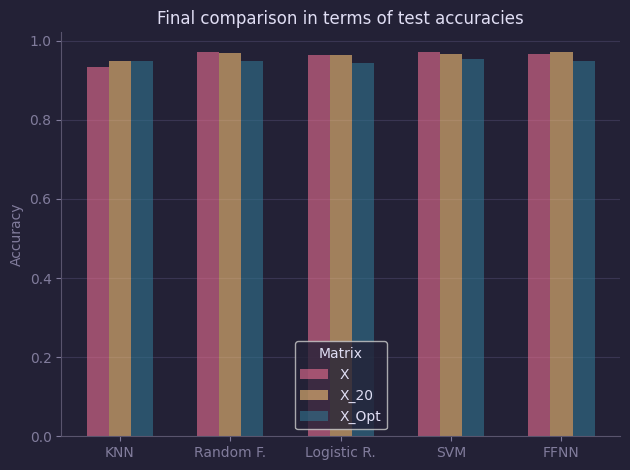

In [235]:
labels = ['KNN', 'Random F.', 'Logistic R.', 'SVM','FFNN']
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, fin_acc_X, width, label='X',alpha=0.6)
rects2 = ax.bar(x, fin_acc_20, width, label='X_20',alpha=0.6)
rects3 = ax.bar(x + width, fin_acc_opt, width, label='X_Opt', color="#31748F",alpha=0.6)

ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(title='Matrix', loc='lower center')
ax.set_title('Final comparison in terms of test accuracies')

fig.tight_layout()
plt.show()


In [236]:
print(f"Accuracies on X:\n{[round(x,3) for x in fin_acc_X]}")
print(f"Accuracies on X_20:\n{[round(x,3) for x in fin_acc_20]}")
print(f"Accuracies on X_opt:\n{[round(x,3) for x in fin_acc_opt]}")
print("---")
print(f"Average accuracy on X: {round(np.mean(fin_acc_X),4)}")
print(f"Average accuracy on X_20: {round(np.mean(fin_acc_20),4)}")
print(f"Average accuracy on X_opt: {round(np.mean(fin_acc_opt),4)}")

Accuracies on X:
[0.933, 0.973, 0.964, 0.973, 0.967]
Accuracies on X_20:
[0.948, 0.97, 0.964, 0.967, 0.973]
Accuracies on X_opt:
[0.948, 0.948, 0.945, 0.955, 0.948]
---
Average accuracy on X: 0.9619
Average accuracy on X_20: 0.9643
Average accuracy on X_opt: 0.949


In summary, the application of Machine Learning techniques on the original dataset did not lead to the Curse of Dimensionality as expected.

Nonetheless, the application of feature selection techniques led to satisfactory results. In all the cases considered, the accuracy on the datasets subjected to PCA is comparable to the ones obtained on the full dataset. This is especially true for the dataset X_20 which, despite having only the 44 most important features, is able to achieve on average a better performance compared to X. The results obtained on X_opt are also notable: while having a slighly lower accuracy, the model is based on a dataset with only three variables.

It is also interesting to notice that the best performing Random Forest over X_Opt has a "max_depth" value of 1; this means that the model is able to achieve an accuracy of almost 95% by separating the each train on a single variable.

Finally, it is worth remembering that L1 regularisation over X drastically reduced the number of features (from 220 to 86) while leaving untouched the accuracy.

We can conclude that feature selection techniques can be a solid choice when applying Machine Learning techniques to psychometric questionnaires with a high number of questions.